# Language Modeling

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai_nlp/'

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
base_dir + 'proc_data/' + 'proc_data.zip'

'/content/gdrive/My Drive/fastai_nlp/proc_data/proc_data.zip'

In [0]:
!unzip '/content/gdrive/My Drive/fastai_nlp/proc_data/all_texts.zip' -d '/content/gdrive/My Drive/fastai_nlp/proc_data/'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *

In [0]:
# bs=48
bs=128

In [0]:
data_path = Path(base_dir + '/proc_data/') #untar_data(URLs.IMDB)
model_path = Path(base_dir + '/models/')

## Language model

### Full dataset

In [0]:
data_lm = (TextList.from_folder(data_path)
            .filter_by_folder(include=['all_texts']) 
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

len(data_lm.vocab.itos),len(data_lm.train_ds)

(21144, 10787)

In [0]:
!ls "/content/gdrive/My Drive/fastai_nlp/proc_data/op_replies"

In [0]:
data_lm.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake']

In [0]:
data_lm.save(data_path/'lm_databunch')

In [0]:
data_lm = load_data(data_path, 'lm_databunch', bs=bs)

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.).to_fp16()

In [0]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


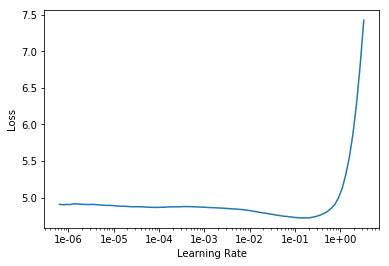

In [0]:
learn_lm.recorder.plot()

In [0]:
lr = 1e-2
lr *= bs/48

In [0]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.155488,3.782548,0.297433,01:13


In [0]:
learn_lm.save(model_path/'sop_baseline')

In [0]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, lr/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.818278,3.653118,0.311968,01:29
1,3.716506,3.571735,0.321503,01:29
2,3.605468,3.518314,0.326854,01:29
3,3.516672,3.468501,0.333508,01:29
4,3.439577,3.427936,0.338726,01:29
5,3.302038,3.400689,0.343010,01:29
6,3.220194,3.372338,0.347076,01:29
7,3.145989,3.356562,0.349755,01:29
8,3.071214,3.351334,0.350976,01:29
9,3.049138,3.351857,0.351254,01:30


In [0]:
learn_lm.save(model_path/'sop_fine_tuned_10')
learn_lm.save_encoder(model_path/'sop_fine_tuned_enc_10')

In [0]:
learn_lm.to_fp32().save(model_path/'sop_fine_tuned_10_fp32', with_opt=False)
learn_lm.data.vocab.save(model_path/('sop_vocab' + '.pkl'))

In [0]:
learn_lm.to_fp32().save(model_path/'sop_fine_tuned_10_fp32_wopt', with_opt=True)

### Only parent posts

In [0]:
def match_sops(filepath):
  return filepath.name.split('.')[0].endswith('0')

data_lm_sop = (TextList.from_folder(data_path/'all_texts')
              .filter_by_func(match_sops)
              .split_by_rand_pct(0.1, seed=42)
              .label_for_lm()           
              .databunch(bs=bs, num_workers=1))

len(data_lm_sop.vocab.itos),len(data_lm_sop.train_ds)

In [0]:
(model_path/'orig_post').mkdir()
model_path_sop = model_path/'orig_post'

In [0]:
data_lm_sop.save(data_path/'lm_sop_databunch')

In [0]:
data_lm_sop = load_data(data_path, 'lm_sop_databunch', bs=bs)

In [0]:
learn_lm_sop = language_model_learner(data_lm_sop, AWD_LSTM, drop_mult=1.).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


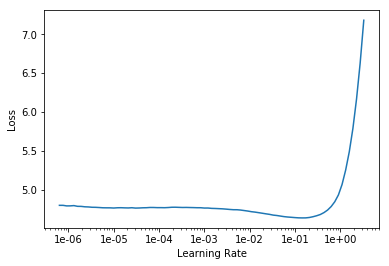

In [0]:
learn_lm_sop.lr_find(); learn_lm_sop.recorder.plot()

In [0]:
lr = 1e-2
lr *= bs/48

In [0]:
learn_lm_sop.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.164935,3.766291,0.304404,00:46


In [0]:
learn_lm_sop.save(model_path_sop/'parent_sop_baseline')

In [0]:
learn_lm_sop.unfreeze()
learn_lm_sop.fit_one_cycle(10, lr/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.831860,3.656862,0.316588,00:55
1,3.726399,3.598825,0.323154,00:54
2,3.619231,3.554218,0.327911,00:54
3,3.515006,3.521124,0.331429,00:54
4,3.407164,3.495150,0.335925,00:55
5,3.306841,3.473606,0.338744,00:54
6,3.203699,3.462002,0.340555,00:54
7,3.094617,3.456797,0.341690,00:54
8,3.027657,3.455701,0.342500,00:54
9,3.013192,3.458644,0.342341,00:55


In [0]:
learn_lm_sop.save(model_path_sop/'parent_sop_fine_tuned_10')
learn_lm_sop.save_encoder(model_path_sop/'parent_sop_fine_tuned_enc_10')

In [0]:
learn_lm_sop.to_fp32().save(model_path_sop/'parent_sop_fine_tuned_10_fp32', with_opt=False)
learn_lm_sop.data.vocab.save(model_path_sop/('parent_sop_vocab' + '.pkl'))

In [0]:
learn_lm_sop.to_fp32().save(model_path_sop/'parent_sop_fine_tuned_10_fp32_wopt', with_opt=True)

### Only Non-OP posts (critiques)

In [0]:
!unzip '/content/gdrive/My Drive/fastai_nlp/proc_data/critiques.zip' -d '/content/gdrive/My Drive/fastai_nlp/proc_data/'

In [0]:
(model_path/'critiques').mkdir()
model_path_crit = model_path/'critiques'

In [0]:
data_lm_crit = (TextList.from_folder(data_path)
            .filter_by_folder(include=['critiques']) 
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

len(data_lm_crit.vocab.itos),len(data_lm_crit.train_ds)

(8448, 4981)

In [0]:
data_lm_crit.save(data_path/'lm_crit_databunch')

In [0]:
data_lm_crit = load_data(data_path, 'lm_sop_databunch', bs=bs)

In [0]:
learn_lm_crit = language_model_learner(data_lm_crit, AWD_LSTM, drop_mult=1.).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


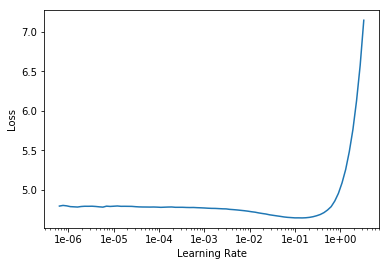

In [0]:
learn_lm_crit.lr_find(); learn_lm_crit.recorder.plot()

In [0]:
lr = 1e-2
lr *= bs/48

In [0]:
learn_lm_crit.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.148306,3.764736,0.305249,00:46


In [0]:
learn_lm_crit.save(model_path_crit/'critiques_baseline')

In [0]:
learn_lm_crit.unfreeze()
learn_lm_crit.fit_one_cycle(10, lr/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.810826,3.657624,0.316473,00:55
1,3.708968,3.598643,0.323830,00:54
2,3.623111,3.558079,0.327105,00:54
3,3.503735,3.516328,0.332165,00:54
4,3.422373,3.486470,0.336145,00:54
5,3.309727,3.476789,0.338262,00:55
6,3.181063,3.461334,0.340966,00:55
7,3.106721,3.455475,0.342321,00:55
8,3.019396,3.455621,0.342742,00:55
9,2.982315,3.456981,0.342733,00:55


In [0]:
learn_lm_crit.save(model_path_crit/'critiques_fine_tuned_10')
learn_lm_crit.save_encoder(model_path_crit/'critiques_fine_tuned_enc_10')

In [0]:
learn_lm_crit.to_fp32().save(model_path_crit/'critiques_fine_tuned_10_fp32', with_opt=False)
learn_lm_crit.data.vocab.save(model_path_crit/('critiques_vocab' + '.pkl'))

In [0]:
learn_lm_crit.to_fp32().save(model_path_crit/'critiques_fine_tuned_10_fp32_wopt', with_opt=True)

### Predict next word / text generation

In [0]:
def text_gen_sample(model, text_primer="data science is", num_words=200, num_sentences=1, temperature=0.75):
  print("\n".join(model.predict(text_primer, num_words, temperature) for _ in range(num_sentences)))

In [0]:
TEXT = "data science is"
N_WORDS = 400
N_SENTENCES = 1

In [0]:
# Sample Combined Sentence
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [0]:
# Sample SoP Sentenence
print("\n".join(learn_lm_sop.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

data science is a world of science , science , technology , and analytics . This requires a profound understanding of the concepts of data science and data mining . Data analytics has always been my interest since my childhood . My curiosity about data analytics led me to choose Data Science as my undergraduate major . During my undergraduate studies , i had a good grasp of Data Science , and realized that Data Science is almost the field i am interested in . At University of Michigan , i spent an entire semester working in a research center . This job taught me the importance of management , strength of data , and the ability to work under pressure . 
 
  As the a year 's internship , i joined the National Information Technology Service Unit ( ENMS ) , the largest Service Provider in Asia . i learned the technical and analytical tools of the CCNA Integrated Protocols and Wifi Protocol , so i was assigned a project of a Standard of Service Obligation ( ENMS ) module . It was a unique e

In [0]:
# Sample Critique Sentenence
print("\n".join(learn_lm_crit.predict("so far i", N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

so far i need to improve my essay . Please feel free to try me out . 
 
  a personal statement that describes your academic interests and your purpose and objectives in undertaking graduate study . 
 
  i am applying for the Master of Engineering program in Economics at XXX . It has made me realize that this is the field of economics that i am interested in . i have always believed that i would have an excellent education in economics . i intend to pursue a Master of Science in Economics at XXX University . My ambition is to pursue my Doctoral studies in Economics and become an economist . 
 
  In my undergraduate studies , i have participated in many extracurricular activities and have been a active participant of many student organizations . As a member of the Society of International Students , i have won several national and national level technical quizzes . During my first year of college , i was a member of the Fourth Annual Student Council of Singapore . i was an active member 

In [0]:
text_gen_sample(learn_lm_crit,'i think you', 200, 1, 0.75)

i think you submit this essay and this type of essay is again an important option for me . This essay is very welcomed . Thanks in advance . 
 
  " Life is full of hardships " , i said it . As i grew older , i have been fascinated to learn more about the human body as well . i began reading articles about business and was intrigued , i wanted to have this opportunity . 
 
  i was chosen by the Department of Science and Technology to attend Pre - University College and a Concentration on Data Science specialized in Data Science at ABC a colleges . i studied Statistics and Math . i was honored with my first choice of the Financial institutions as my major from both the University and College . i not only excelled in math , mathematics , physics , philosophy and chemistry but also excelled by teaching . By being in the Top five to curemd like Mathematics , i excelled in Physics , Mathematics and Chemistry


**Train more**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-04


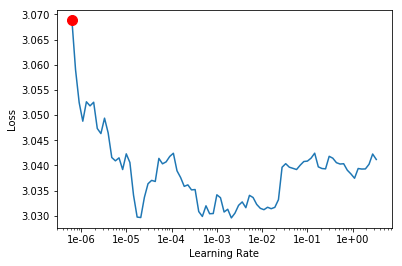

In [0]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)